In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# turn off warning
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("data/raw/dev_data.csv")
print("Full dataset has", df.shape[0], "rows and", df.shape[1], "columns")

Full dataset has 96806 rows and 1216 columns


# Data exploration

In [4]:
df.head()

,account_number,bad_flag,onus_attribute_1,transaction_attribute_1,transaction_attribute_2,transaction_attribute_3,transaction_attribute_4,transaction_attribute_5,transaction_attribute_6,transaction_attribute_7,...,bureau_enquiry_47,bureau_enquiry_48,bureau_enquiry_49,bureau_enquiry_50,onus_attribute_43,onus_attribute_44,onus_attribute_45,onus_attribute_46,onus_attribute_47,onus_attribute_48
0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0,221000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0,25000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN
3,4,0,86000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN
4,5,0,215000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
total_missing = df.isnull().sum().sum()
total_elements = df.size

percent_missing = (total_missing / total_elements) * 100

print("Percentage of missing data: {:.2f}%".format(percent_missing))

Percentage of missing data: 16.46%


As we can see, thats a lot of missing data. Either need to impute the dataset, or remove unnecessary features, or both.

Apart from that, we need to check whether the dataset has columns which are all empty, sum is zero, or have no distict values.
We need to drop those.

No Defaults: 98.58 % of the dataset
Defaults: 1.42 % of the dataset


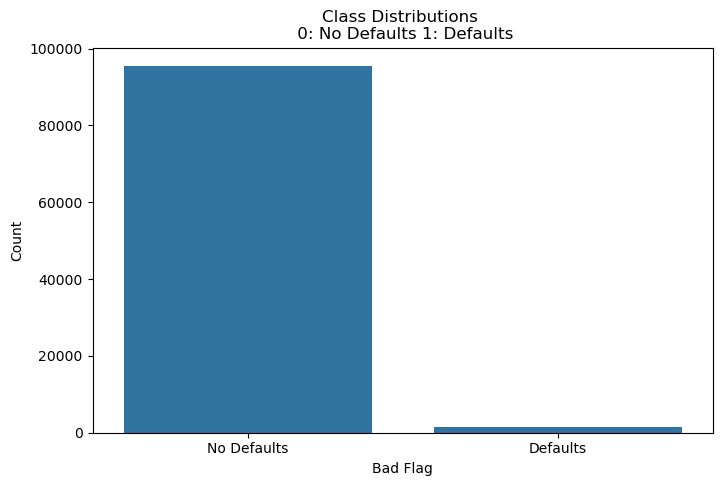

In [6]:
no_defaults_percentage = round(df["bad_flag"].value_counts()[0] / len(df) * 100, 2)
defaults_percentage = round(df["bad_flag"].value_counts()[1] / len(df) * 100, 2)

print("No Defaults:", no_defaults_percentage, "% of the dataset")
print("Defaults:", defaults_percentage, "% of the dataset")

plt.figure(figsize=(8, 5))
sns.countplot(x="bad_flag", data=df)
plt.title("Class Distributions \n 0: No Defaults 1: Defaults")
plt.xlabel("Bad Flag")
plt.ylabel("Count")
plt.xticks(
    ticks=[0, 1], labels=["No Defaults", "Defaults"]
)
plt.show()

Clearly, the dataset is heavily imbalanced. We can consider resampling techniques.

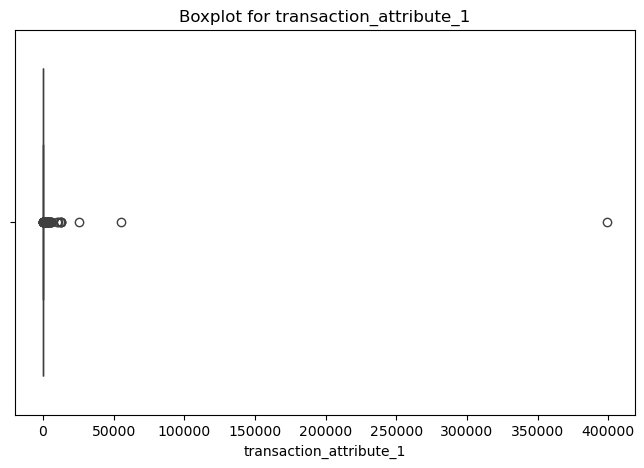

Number of outliers in transaction_attribute_1: 14


In [7]:
column_name = "transaction_attribute_1"  # Replace with the column you want to analyze

# Plot a boxplot to visualize outliers
plt.figure(figsize=(8, 5))
sns.boxplot(x=df[column_name])
plt.title(f"Boxplot for {column_name}")
plt.xlabel(column_name)
plt.show()

# Calculate Z-scores for the column
z_scores = (df[column_name] - df[column_name].mean()) / df[column_name].std()

# Identify outliers (Z-score > 3 or < -3)
outliers = df[np.abs(z_scores) > 3]

# Print the number of outliers and display them
print(f"Number of outliers in {column_name}: {len(outliers)}")

The dataset has outliers. We may need to clip them, though we need to consider that removing them may cause loss of information.

employing a power transformer when using LightGBM enhances feature distributions, mitigates outlier effects, facilitates gradient boosting processes, aids in dimensionality reduction, and improves integration with other models. These factors collectively contribute to building more robust and accurate predictive models.

so we use Yeo-Jhonson transformer to stabilize variance and make the data more normally distributed.

In [ ]:
# Example code

from sklearn.preprocessing import PowerTransformer

def yeo_johnson_transform_skewed_features(data_path, skew_threshold=0.75):
    data = pd.read_parquet(data_path)
    numeric_cols = data.select_dtypes(
        include=["float64", "float32", "int64", "int32"]
    ).columns
    numeric_cols = [col for col in numeric_cols if col != "account_number"]
    
    skewed_features = data[numeric_cols].apply(lambda x: x.skew()).abs()
    skewed_cols = skewed_features[skewed_features > skew_threshold].index

    print(f"***Applying Yeo-Johnson transformation to {len(skewed_cols)} skewed features***")

    transformer = PowerTransformer(method='yeo-johnson')
    data[skewed_cols] = transformer.fit_transform(data[skewed_cols])

    data.to_parquet(data_path, index=False)
    print(f"***Yeo-Johnson transformation applied and saved to {data_path}***")


Now, for addressing class imbalance in datasets, particularly in binary classification tasks, the SMOTE-Tomek resampling method can be highly beneficial.
SMOTE (Synthetic Minority Over-sampling Technique) generates synthetic samples for the minority class, while Tomek links help identify and remove overlapping instances between classes. 


In [1]:
# Example code

def resample_training_data(data_path, target_column):
    """
    Load a training dataset from a Parquet file, perform SMOTE-Tomek resampling,
    and save the resampled dataset as a Parquet file.
    """
    data = pd.read_parquet(data_path)
    print(f"Loaded training data with shape: {data.shape}")

    X = data.drop(columns=[target_column])
    y = data[target_column]

    if y.nunique() != 2:
        raise ValueError(
            "Target column must contain exactly two unique values for binary classification."
        )

    if y.dtype not in ["int64", "int32", "category"]:
        print("Converting continuous target to binary classes")
        y = y.astype("int")

    smote_tomek = SMOTETomek(random_state=42)
    print("Performing SMOTE-Tomek resampling...")
    X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

    resampled_data = pd.concat(
        [
            pd.DataFrame(X_resampled, columns=X.columns),
            pd.DataFrame(y_resampled, columns=[target_column]),
        ],
        axis=1,
    )

    print(f"Resampled data shape: {resampled_data.shape}")

    resampled_data.to_parquet(data_path, index=False)
    print(f"***Resampled data saved to: {data_path}***")
    